In [50]:
import numpy as np
import json
import csv

k = 5
X = np.genfromtxt('../data/impute_ordhinge_X_offset%d.csv' % k, delimiter=',').T
Y = np.genfromtxt('../data/impute_ordhinge_Y_offset%d.csv' % k, delimiter=',')

entry_test_data = np.genfromtxt('../data/all_samples_filtered_entry_test.csv', delimiter=',')
instrument_test_data = np.genfromtxt('../data/all_samples_filtered_instrument_test.csv', delimiter=',')
train_data = np.genfromtxt('../data/all_samples_filtered_train.csv', delimiter=',')
m, n = train_data.shape
print(train_data.shape, entry_test_data.shape)

with open('../data/all_samples.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    key_to_index = dict([(h, i) for i, h in enumerate(header)])
    data_labels = list(reader)
    
all_samples_filtered = np.genfromtxt('../data/all_samples_filtered_train.csv', delimiter=',')

with open('../data/all_samples_filtered.csv', 'r') as f:
    reader = csv.reader(f)
    features = next(reader)[1:]
    
print('Num features', len(features), features[:5])

def get_label(i, key):
    return data_labels[i][key_to_index[key]]
print(X.shape, Y.shape)

(16291, 250) (16291, 250)
Num features 250 ['ADIR:Q11', 'ADIR:Q12', 'ADIR:Q13', 'ADIR:Q14', 'ADIR:Q15']
(16291, 5) (5, 251)


In [46]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=.5, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [85]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage='ward', n_clusters=5)
clustering.fit(X)
print(clustering.labels_)
labels = clustering.labels_
n_clusters_ = 4

[0 0 0 ..., 2 2 2]


In [86]:
from sklearn import metrics

print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 4
Silhouette Coefficient: 0.207


In [89]:
plt.figure(figsize=(10, 7))

for option in ['Autism', 'Control', 'PDD-NOS', 'Asperger']:
    indices = [i for i in range(m) if data_labels[i][1] == option]
    print(len(indices))
    plt.scatter(X[indices, 0], X[indices, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k', label=option)
plt.legend()
plt.show()

10478


IndexError: index 252 is out of bounds for axis 0 with size 251

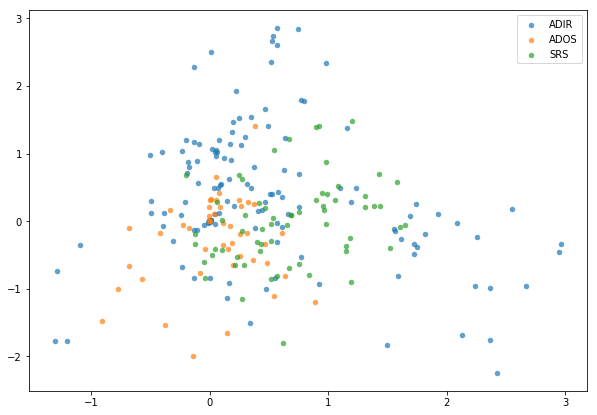

In [95]:
plt.figure(figsize=(10, 7))

adir_indices = list(range(0, 139))
ados_indices = list(range(139, 185))
srs_indices = list(range(185, 249))

plt.scatter(Y.T[adir_indices, 0], Y.T[adir_indices, 1], marker='o', s=30, lw=0, alpha=0.7, edgecolor='k', label='ADIR')
plt.scatter(Y.T[ados_indices, 0], Y.T[ados_indices, 1], marker='o', s=30, lw=0, alpha=0.7, edgecolor='k', label='ADOS')
plt.scatter(Y.T[srs_indices, 0], Y.T[srs_indices, 1], marker='o', s=30, lw=0, alpha=0.7, edgecolor='k', label='SRS')

plt.legend()
plt.show()

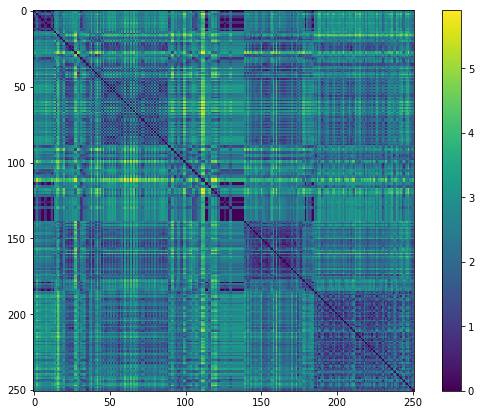

In [100]:
from scipy.spatial import distance_matrix

plt.figure(figsize=(10, 7))
ax1 = plt.imshow(distance_matrix(Y.T, Y.T))
plt.colorbar(ax1)
plt.show()

In [107]:
import seaborn as sns; sns.set()
g = sns.clustermap(Y)

//anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


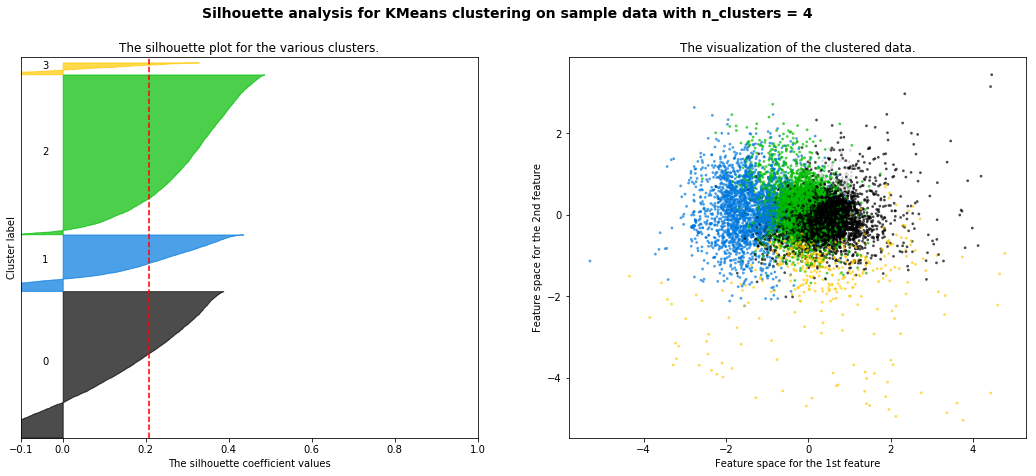

In [88]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters_ + 1) * 10])


# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = metrics.silhouette_score(X, labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(X, labels)

y_lower = 10
for i in range(n_clusters_):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.spectral(float(i) / n_clusters_)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.spectral(labels.astype(float) / n_clusters_)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
               "with n_clusters = %d" % n_clusters_),
             fontsize=14, fontweight='bold')

plt.show()